In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import re
from sklearn.metrics import pairwise_distances
from sacremoses import MosesDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string

In [2]:
#Import South Park Script
southpark = pd.read_csv("All-seasons.csv")
southpark.head()

,Season,Episode,Character,Line
0,1,1,Boys,"School day, school day, teacher's golden ru...\n"
1,1,1,Kyle,"Ah, damn it! My little brother's trying to fol..."
2,1,1,Ike,Zeeponanner.\n
3,1,1,Kyle,"Ike, you can't come to school with me. \n"
4,1,1,Cartman,"Yeah, go home you little dildo.\n"


In [3]:
#Dialogue spoken by Cartman
cart = southpark['Character'] == 'Cartman'
cartman = southpark[cart]
cartman.head()

,Season,Episode,Character,Line
4,1,1,Cartman,"Yeah, go home you little dildo.\n"
8,1,1,Cartman,I know what it means!\n
10,1,1,Cartman,I'm not telling you.\n
13,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
19,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [4]:
#Reset index
cartman = cartman.reset_index(drop=True)
cartman.head()

,Season,Episode,Character,Line
0,1,1,Cartman,"Yeah, go home you little dildo.\n"
1,1,1,Cartman,I know what it means!\n
2,1,1,Cartman,I'm not telling you.\n
3,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
4,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [5]:
# Expand Contractions
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
cartman['Line_process'] = cartman['Line'].apply(decontracted)
cartman['Line_process'].head(25)

0                     Yeah, go home you little dildo.\n
1                               I know what it means!\n
2                               I am not telling you.\n
3     He-yeah, that is what Kyle is little brother i...
4     That is 'cause I was having these... bogus nig...
5     Well, I dreamt that I was lying in my bed...  ...
6                                               What?\n
7            No, it was just a dream, my mom said so.\n
8     Oh, shut up guys! You are just trying to make ...
9                                           Kick ass.\n
10                                               Huh?\n
11    Eh, no, that, that was just a dream. And I am ...
12                                                Oh!\n
13                                                Oh!\n
14         No! Uh-I mean, eh, why would they do that?\n
15                                                No!\n
16                                    Shut up, dildo!\n
17                                              

In [6]:
#Lowercase
cartman['Line_process'] = cartman['Line_process'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cartman['Line_process'].head(25)

0                       yeah, go home you little dildo.
1                                 i know what it means!
2                                 i am not telling you.
3     he-yeah, that is what kyle is little brother i...
4     that is 'cause i was having these... bogus nig...
5     well, i dreamt that i was lying in my bed... i...
6                                                 what?
7              no, it was just a dream, my mom said so.
8     oh, shut up guys! you are just trying to make ...
9                                             kick ass.
10                                                 huh?
11    eh, no, that, that was just a dream. and i am ...
12                                                  oh!
13                                                  oh!
14           no! uh-i mean, eh, why would they do that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [7]:
#Remove Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
cartman['Line_process'] = cartman['Line_process'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
cartman['Line_process'].head(25)

0                           yeah, go home little dildo.
1                                           know means!
2                                          telling you.
3               he-yeah, kyle little brother right! ow!
4                     'cause these... bogus nightmares.
5     well, dreamt lying bed... dark, sudden bright ...
6                                                 what?
7                               no, dream, mom said so.
8           oh, shut guys! trying make scared. working.
9                                             kick ass.
10                                                 huh?
11                 eh, no, that, dream. fat, big boned!
12                                                  oh!
13                                                  oh!
14                       no! uh-i mean, eh, would that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [8]:
#Remove Punctuation
cartman['Line_process'] = cartman['Line_process'].str.replace('[^\w\s]','')
cartman['Line_process'].head(25)

0                             yeah go home little dildo
1                                            know means
2                                           telling you
3                   heyeah kyle little brother right ow
4                          cause these bogus nightmares
5     well dreamt lying bed dark sudden bright blue ...
6                                                  what
7                                  no dream mom said so
8               oh shut guys trying make scared working
9                                              kick ass
10                                                  huh
11                       eh no that dream fat big boned
12                                                   oh
13                                                   oh
14                            no uhi mean eh would that
15                                                   no
16                                        shut up dildo
17                                              

In [9]:
#Tokenize
cartman['word_tokens'] = cartman['Line_process'].apply(word_tokenize)

In [10]:
cartman['word_tokens'].head(25)

0                       [yeah, go, home, little, dildo]
1                                         [know, means]
2                                        [telling, you]
3            [heyeah, kyle, little, brother, right, ow]
4                     [cause, these, bogus, nightmares]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8       [oh, shut, guys, trying, make, scared, working]
9                                           [kick, ass]
10                                                [huh]
11               [eh, no, that, dream, fat, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

In [11]:
#Lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
cartman['word_tokens'].apply(lemmatize_text).head(25)

0                       [yeah, go, home, little, dildo]
1                                          [know, mean]
2                                        [telling, you]
3            [heyeah, kyle, little, brother, right, ow]
4                      [cause, these, bogus, nightmare]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8        [oh, shut, guy, trying, make, scared, working]
9                                            [kick, as]
10                                                [huh]
11               [eh, no, that, dream, fat, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

In [12]:
#Convert Word Tokens to String
md = MosesDetokenizer(lang = 'en')
cartman['token_string'] = cartman['word_tokens'].apply(lambda x: md.detokenize(x, return_str=True))
cartman['token_string'].head(25)

0                             yeah go home little dildo
1                                            know means
2                                           telling you
3                   heyeah kyle little brother right ow
4                          cause these bogus nightmares
5     well dreamt lying bed dark sudden bright blue ...
6                                                  what
7                                  no dream mom said so
8               oh shut guys trying make scared working
9                                              kick ass
10                                                  huh
11                       eh no that dream fat big boned
12                                                   oh
13                                                   oh
14                            no uhi mean eh would that
15                                                   no
16                                        shut up dildo
17                                              

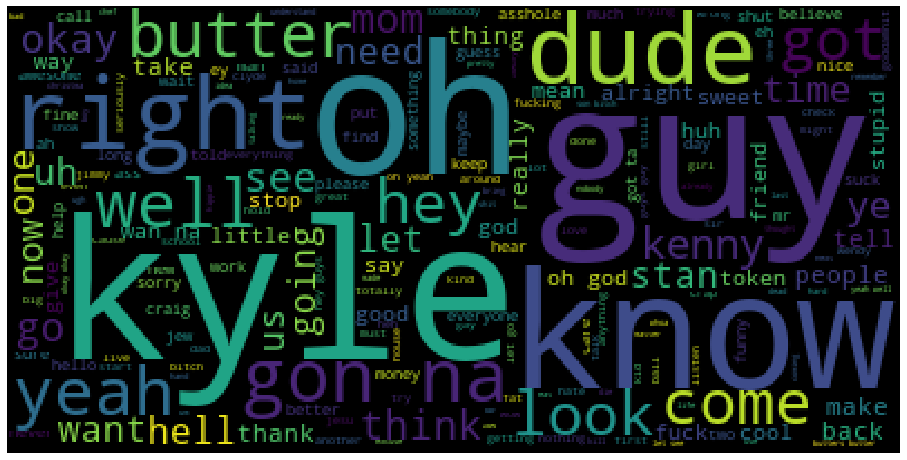

In [13]:
#Wordcloud
wordcloud_cartman = WordCloud().generate(cartman['word_tokens'].to_string())
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud_cartman)
plt.axis("off")
plt.savefig('Cartman_Wordcloud.png')
plt.show()

In [14]:
#Bag of Word Model
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
vec = CountVectorizer()
bag_of_words = vec.fit_transform(cartman['token_string'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = np.array(sorted(words_freq, key = lambda x: x[1], reverse=True))

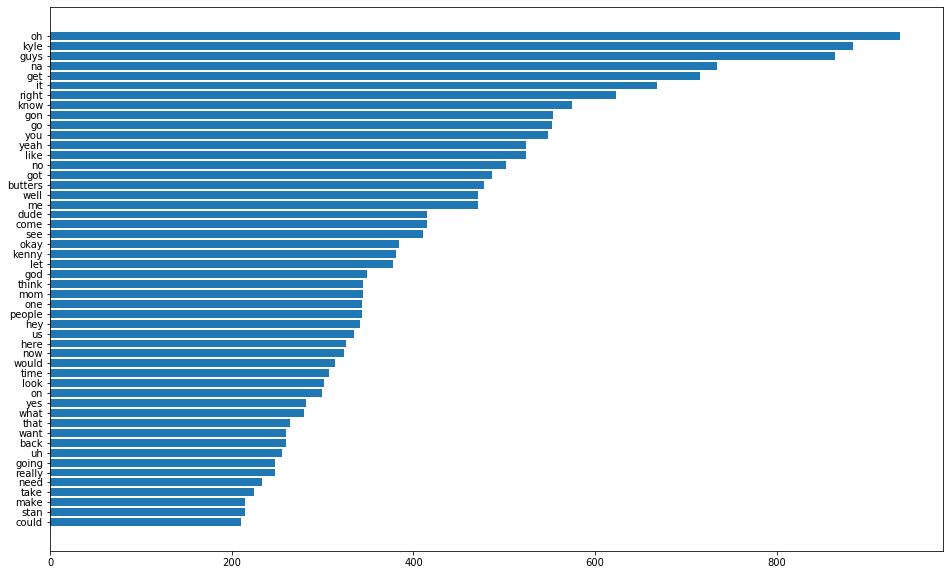

In [16]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), words_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=words_freq[:n, 0])
plt.savefig('Cartman_BOW.png')
plt.show()

In [17]:
#TF-IDF
vect = TfidfVectorizer()
tfidf = vect.fit_transform(cartman['token_string'])
sum_tfidf = tfidf.sum(axis=0)
tfidf_freq = [(word, sum_tfidf[0, idx]) for word, idx in vect.vocabulary_.items()]
tfidf_freq = np.array(sorted(tfidf_freq, key = lambda x: x[1], reverse=True))

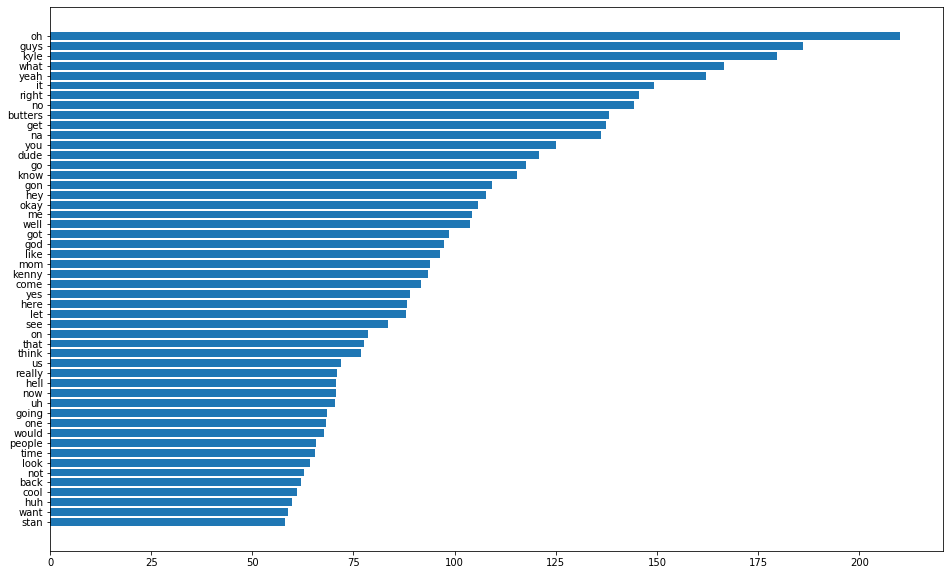

In [18]:
n = 50
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), tfidf_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=tfidf_freq[:n, 0])
plt.savefig('Cartman_TFIDF.png')
plt.show()

In [19]:
#Chatbot

In [20]:
#Create New Dataframe of Bag of Words Array
bow = vec.fit_transform(cartman['token_string']).toarray()
features = vec.get_feature_names()
cartman_bow = pd.DataFrame(bow, columns = features)
cartman_bow.head()

,10,1000,1030,104,1045,10th,11,1146,12,1230,...,zippers,zombie,zombies,zoo,zookeeper,zookeepier,zoomed,zu,zzzzsssht,zzzzt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#Create New Dataframe of TFIDF Array
vectorize = vect.fit_transform(cartman['token_string']).toarray()
features = vect.get_feature_names()
cartman_tfidf = pd.DataFrame(vectorize, columns = features)
cartman_tfidf.head()

,10,1000,1030,104,1045,10th,11,1146,12,1230,...,zippers,zombie,zombies,zoo,zookeeper,zookeepier,zoomed,zu,zzzzsssht,zzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
punctuation_removal = dict((ord(punctuation), None) for punctuation in string.punctuation)

In [23]:
def get_processed_text(document):
    return lemmatize_text(nltk.word_tokenize(document.lower().translate(punctuation_removal)))

In [ ]:
greeting_inputs = ("hey", "good morning", "good evening", "morning", "evening", "hi", "whatsup")
greeting_responses = ["hey", "hey hows you?", "*nods*", "hello, how you doing", "hello", "Welcome, I am good and you"]

def generate_greeting_response(greeting):
    for token in greeting.split():
        if token.lower() in greeting_inputs:
            return random.choice(greeting_responses)

In [ ]:
def generate_response(user_input):
    cartman_response = ''
    article_sentences.append(user_input)

    word_vectorizer = TfidfVectorizer(tokenizer=get_processed_text, stop_words='english')
    all_word_vectors = word_vectorizer.fit_transform(article_sentences)
    similar_vector_values = cosine_similarity(all_word_vectors[-1], all_word_vectors)
    similar_sentence_number = similar_vector_values.argsort()[0][-2]

    matched_vector = similar_vector_values.flatten()
    matched_vector.sort()
    vector_matched = matched_vector[-2]

    if vector_matched == 0:
        tennisrobo_response = tennisrobo_response + "I am sorry, I could not understand you"
        return tennisrobo_response
    else:
        tennisrobo_response = tennisrobo_response + article_sentences[similar_sentence_number]
        return tennisrobo_response

In [ ]:
continue_dialogue = True
print("Hello, I am your friend Cartman. You can ask me any question regarding South Park:")
while(continue_dialogue == True):
    human_text = input()
    human_text = human_text.lower()
    if human_text != 'bye':
        if human_text == 'thanks' or human_text == 'thank you very much' or human_text == 'thank you':
            continue_dialogue = False
            print("Cartman: Most welcome")
        else:
            if generate_greeting_response(human_text) != None:
                print("Cartman: " + generate_greeting_response(human_text))
            else:
                print("Cartman: ", end="")
                print(generate_response(human_text))
                article_sentences.remove(human_text)
    else:
        continue_dialogue = False
        print("Cartman: Good bye and take care of yourself...")